# Initialization

In [1]:
# Business Analysis
# Yilong Li

%matplotlib notebook
import graph_tool
import snap
import numpy as np
from pymongo import MongoClient, GEOSPHERE
from matplotlib import pylab as plt
import operator
from IPython.display import HTML, display
import tabulate
from scipy import stats
import collections

In [2]:
# Database client

client = MongoClient('localhost', 27272)
db = client.test
business = db.business
reviews = db.review
users = db.users

In [3]:
top_cities = [u'Las Vegas',
 u'Phoenix',
 u'Toronto',
 u'Charlotte',
 u'Scottsdale',
 u'Calgary',
 u'Pittsburgh',
 u'Mesa',
 u'Montr\xe9al',
 u'Henderson']


# Relative Ranking Calculation & Integration into DB

In [33]:
city = top_cities[:10]

In [39]:
db.newBusiness.aggregate([
    {
        '$match' : {
            'city' : { '$in' : city } , 
            'review_count' : { '$gte' : 20 }
        }
    },
    {
        '$out': 'city_business'
    }
])


In [40]:
db.city_business.create_index([('loc', GEOSPHERE)])
db.city_business.create_index('business_id')

u'business_id_1'

In [41]:
dict_within_radius = collections.defaultdict(dict)

In [42]:
city_business = db.city_business.find({})

In [ ]:
radius = 1609 * 2 # unit: m

count = 0
total =  db.city_business.count_documents({})
for business in city_business:
    longitude, latitude = business['longitude'], business['latitude']
    business_within_radius = list(db.city_business.find(
        {
            'loc' : {
                '$near': {
                    '$geometry': {
                        'type' : 'Point' , 'coordinates' : [ longitude, latitude ]
                    }, 
                    '$maxDistance': radius
                }
            },
        },
        {
            '_id': 0,
            'business_id': 1
        }
    ))
    business_within_radius_list = [x['business_id'] for x in business_within_radius]
    dict_within_radius[radius][business['business_id']] = business_within_radius_list
    result = db.city_business.update_many(
        {
            'business_id' : business['business_id']
        },
        {
            '$set': {
                'pts_within_2mi': len(business_within_radius_list) 
            }
        }
    )
    if result.modified_count != 1: 
        print business, result.matched_count, result.modified_count
    count += 1
    if count % 1000 == 0:
        print count, '/', total

1000 / 36780
2000 / 36780
3000 / 36780
4000 / 36780
5000 / 36780
6000 / 36780
7000 / 36780
8000 / 36780
9000 / 36780
10000 / 36780
11000 / 36780
12000 / 36780
13000 / 36780
14000 / 36780
15000 / 36780
16000 / 36780
17000 / 36780
18000 / 36780
19000 / 36780
20000 / 36780
21000 / 36780
22000 / 36780
23000 / 36780
24000 / 36780
25000 / 36780
26000 / 36780


<IPython.core.display.Javascript object>


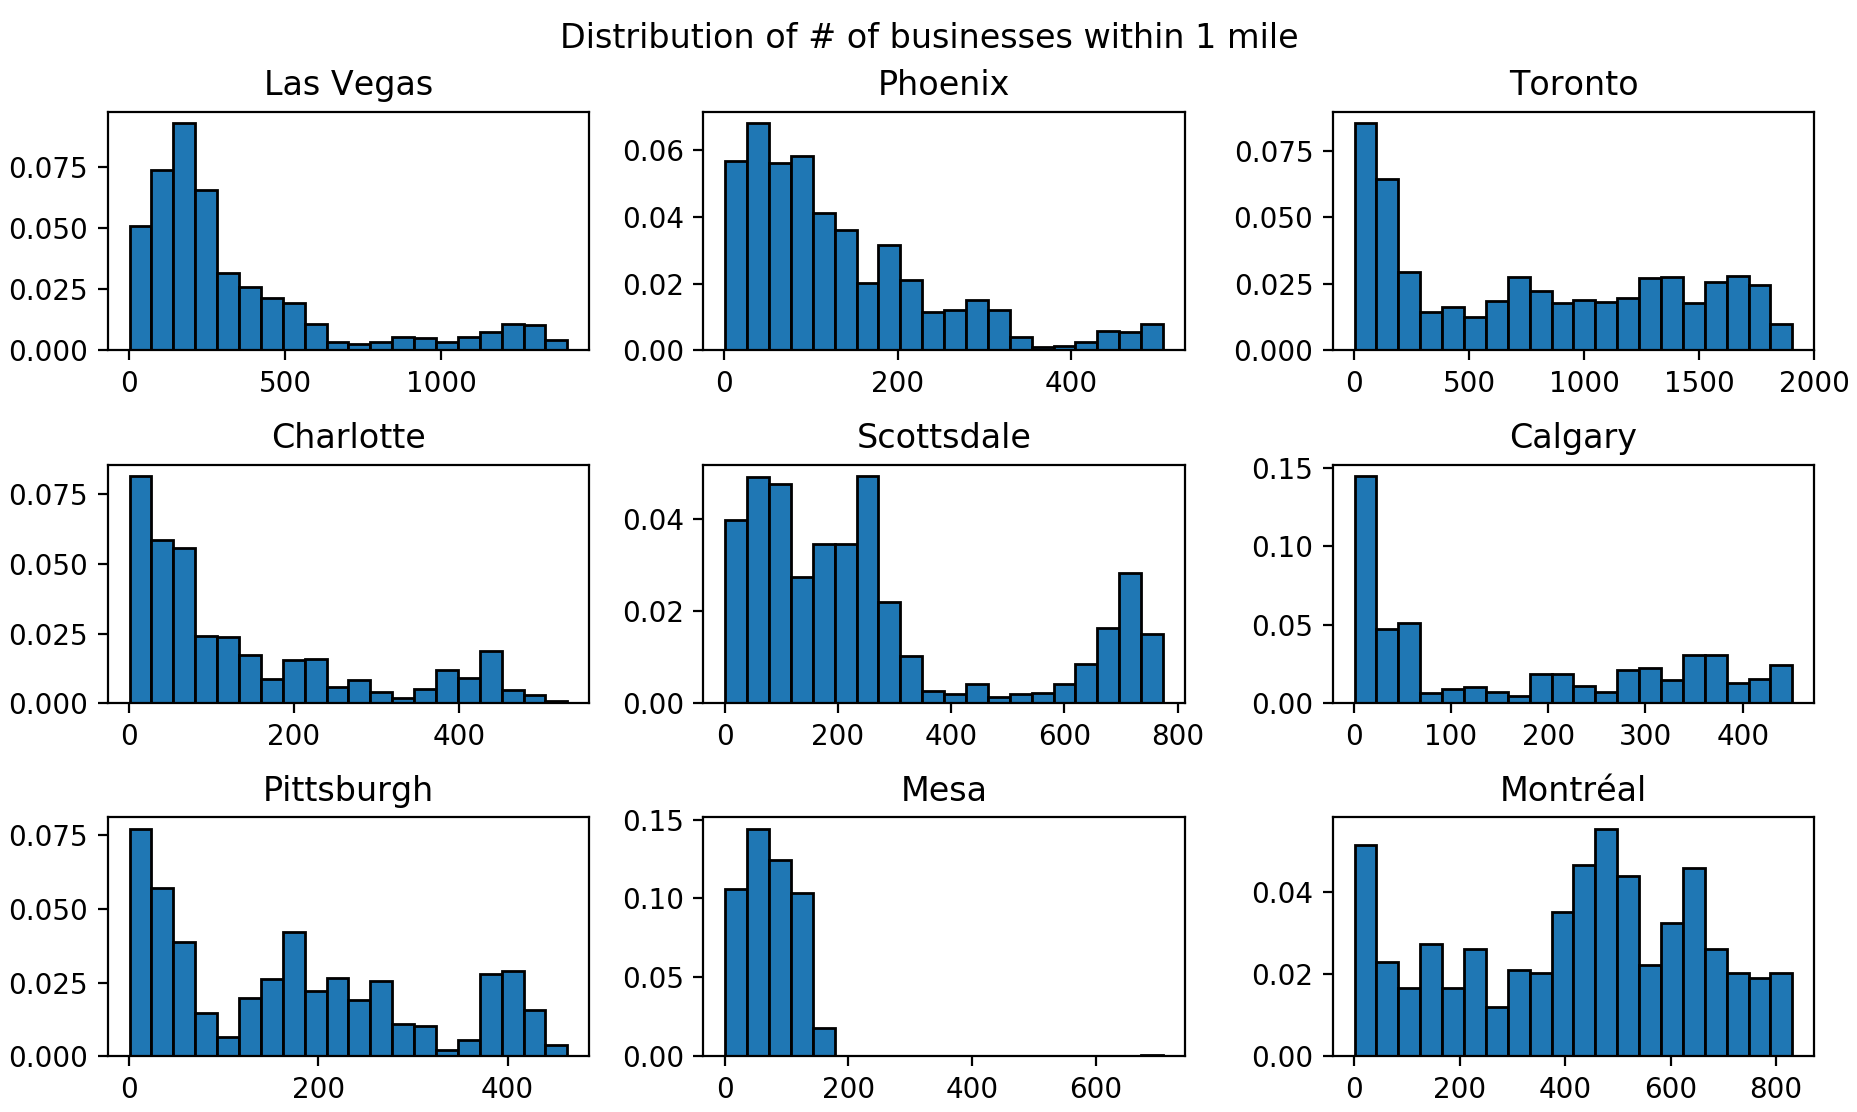

In [89]:
# Distribution of # of points within 1mile
cmap=plt.cm.get_cmap(plt.cm.autumn)

distribution_np_within_1_mile = list(db.city_business.aggregate([
    {
        '$group': {
            '_id': '$city',
            'pts_within_1mi': { '$push' : '$pts_within_1mi' },
            'total_business': { '$sum' : 1 }
        }
    }
]))

index = 0
fig, axs = plt.subplots(3, 3, constrained_layout=True)
axs = axs.flatten()
for city in top_cities[:9]:
    distribution = [kv for kv in distribution_np_within_1_mile if kv['_id'] == city][0]
    ax = axs[index]
    city_name = distribution['_id']
    ax.set_title(city_name)
    ax.hist(distribution['pts_within_1mi'], linewidth=1, edgecolor='black', bins=20, 
            weights = np.zeros_like(distribution['pts_within_1mi']) + 1. / distribution['total_business'])
    index += 1
fig.suptitle('Distribution of # of businesses within 1 mile')
plt.show()

<IPython.core.display.Javascript object>


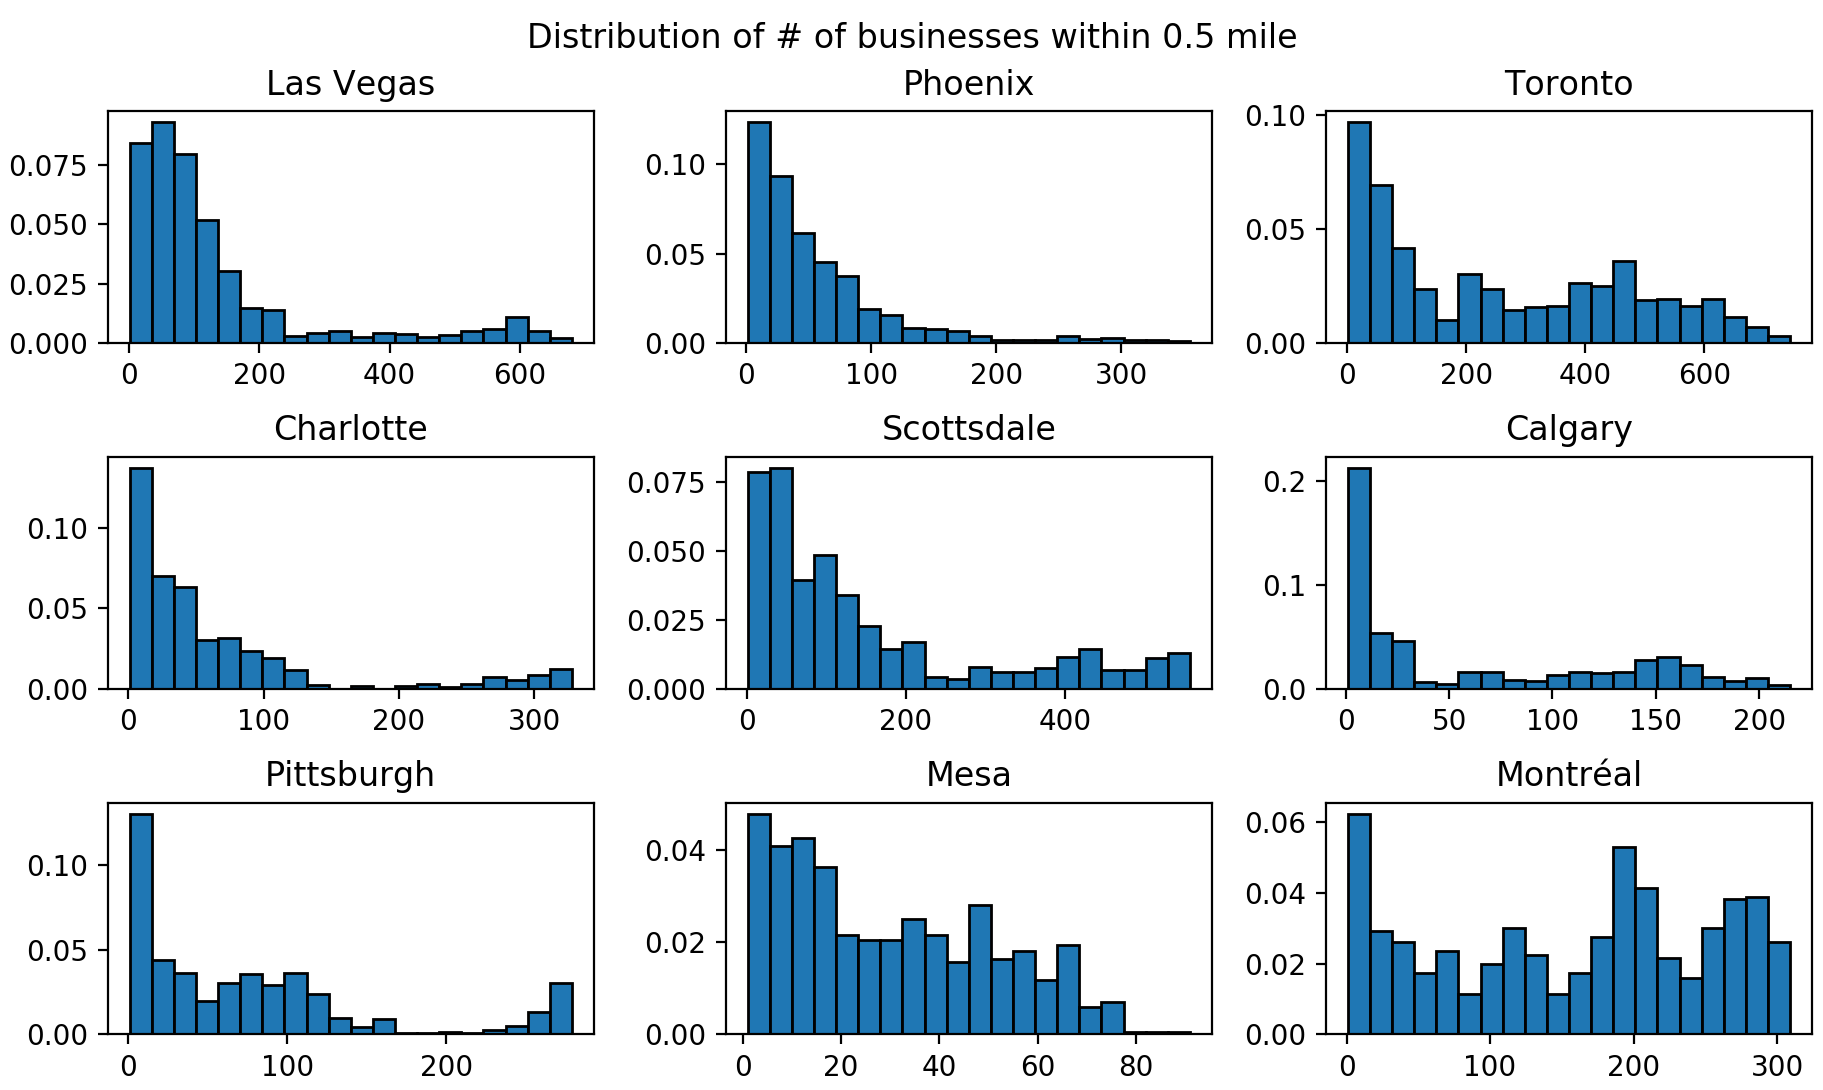

In [101]:
# Distribution of # of points within 0.5 mile
cmap=plt.cm.get_cmap(plt.cm.autumn)

distribution_np_within_0_5_mile = list(db.city_business.aggregate([
    {
        '$group': {
            '_id': '$city',
            'pts_within_05mi': { '$push' : '$pts_within_0.5mi' },
            'total_business': { '$sum' : 1 }
        }
    }
]))

index = 0
fig, axs = plt.subplots(3, 3, constrained_layout=True)
axs = axs.flatten()
for city in top_cities[:9]:
    distribution = [kv for kv in distribution_np_within_0_5_mile if kv['_id'] == city][0]
    ax = axs[index]
    city_name = distribution['_id']
    ax.set_title(city_name)
    ax.hist(distribution['pts_within_05mi'], linewidth=1, edgecolor='black', bins=20, 
            weights = np.zeros_like(distribution['pts_within_05mi']) + 1. / distribution['total_business'])
    index += 1
fig.suptitle('Distribution of # of businesses within 0.5 mile')
plt.show()

<IPython.core.display.Javascript object>


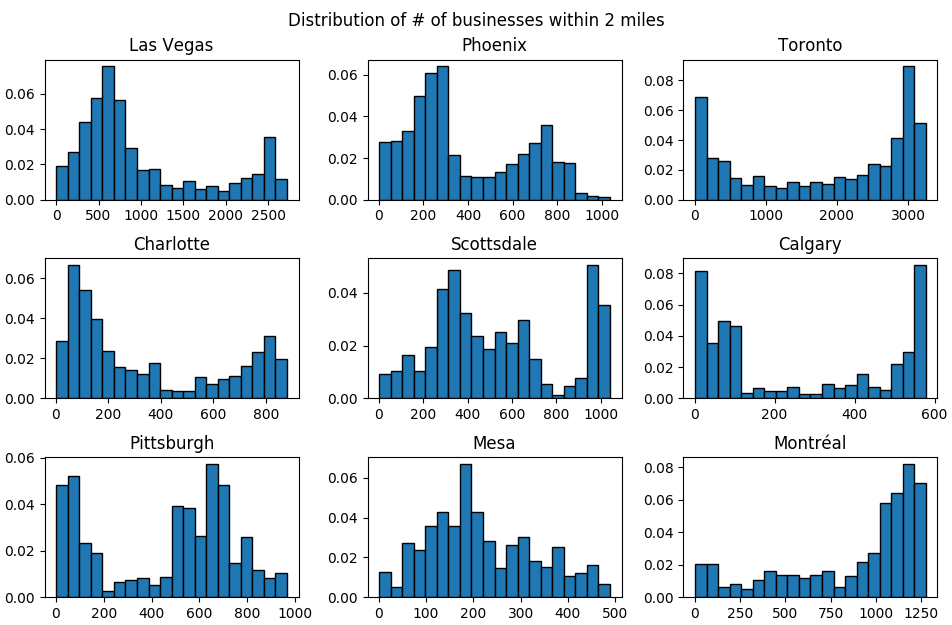

In [135]:
# Distribution of # of points within 0.5 mile
cmap=plt.cm.get_cmap(plt.cm.autumn)

distribution_np_within_2_mile = list(db.city_business.aggregate([
    {
        '$group': {
            '_id': '$city',
            'pts_within_2mi': { '$push' : '$pts_within_2mi' },
            'total_business': { '$sum' : 1 }
        }
    }
]))

index = 0
fig, axs = plt.subplots(3, 3, constrained_layout=True)
axs = axs.flatten()
for city in top_cities[:9]:
    distribution = [kv for kv in distribution_np_within_2_mile if kv['_id'] == city][0]
    ax = axs[index]
    city_name = distribution['_id']
    ax.set_title(city_name)
    ax.hist(distribution['pts_within_2mi'], linewidth=1, edgecolor='black', bins=20, 
            weights = np.zeros_like(distribution['pts_within_2mi']) + 1. / distribution['total_business'])
    index += 1
fig.suptitle('Distribution of # of businesses within 2 miles')
plt.show()

## Calculate relative ranking by review counts

In [44]:
import json 

radius = 1609 * 2 # 2 mile
sort_by = 'review_count' # stars or review_count

city_business = db.city_business.find({})

count = 0
total =  db.city_business.count_documents({})
rank_by_city = collections.defaultdict(list)


map_business_ranking = {}

for business in city_business:
    business_id, longitude, latitude = business['business_id'], business['longitude'], business['latitude']
    business_within_radius_list = dict_within_radius[radius][business_id]
    business_with_ranking = list(db.city_business.aggregate([
        {
            '$match' : { 'business_id' : { '$in' : business_within_radius_list } }
        },
        {
            '$sort': { sort_by : -1 },
        },
        {
            "$group": {
                "_id": 0,
                "items": { "$push": "$$ROOT" }
            }
        },
        {
            "$unwind": { "path": "$items", "includeArrayIndex": "items.rank" } 
        },
        {
            "$replaceRoot": { "newRoot": "$items" } 
        },
        {
            "$match": { "business_id" : business_id } 
        }
    ]))[0]
    
    rank_by_city[business['city']].append(business_with_ranking['rank'])
    map_business_ranking[business_id] = {
        'rank': business_with_ranking['rank'],
        'neighbors': business['pts_within_2mi']
    }
    count += 1
    if count % 1000 == 0:
        print count

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000


In [18]:
business_with_ranking.items()[0]

(u'city', u'Las Vegas')

In [45]:
# store business - ranking pair to dictionary

json.dump(map_business_ranking, open('business-ranking.json', 'w'))

<IPython.core.display.Javascript object>


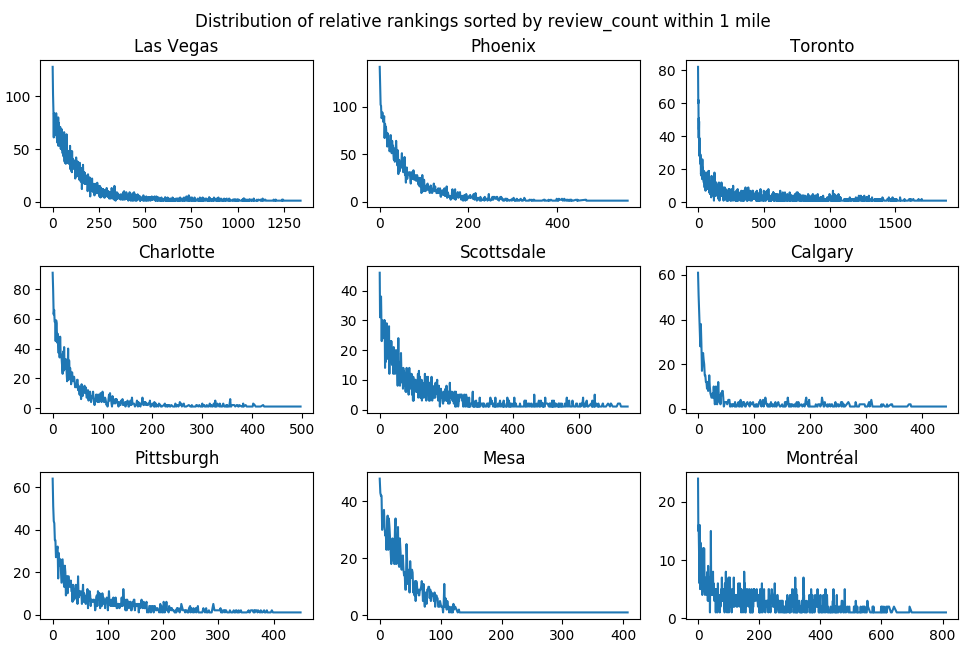

In [153]:
# Distribution of relative ranks sorted by review count within 1 mile

rank_dist_1mi = rank_by_city.copy()

index = 0
fig, axs = plt.subplots(3, 3, constrained_layout=True)
axs = axs.flatten()
for city in top_cities[:9]:
    counter = collections.Counter(rank_by_city[city])
    x, y = zip(*counter.items())
    ax = axs[index]
    ax.set_title(city)
    ax.plot(x, y)
    index += 1
fig.suptitle('Distribution of relative rankings sorted by review_count within 1 mile')
plt.show()

<IPython.core.display.Javascript object>


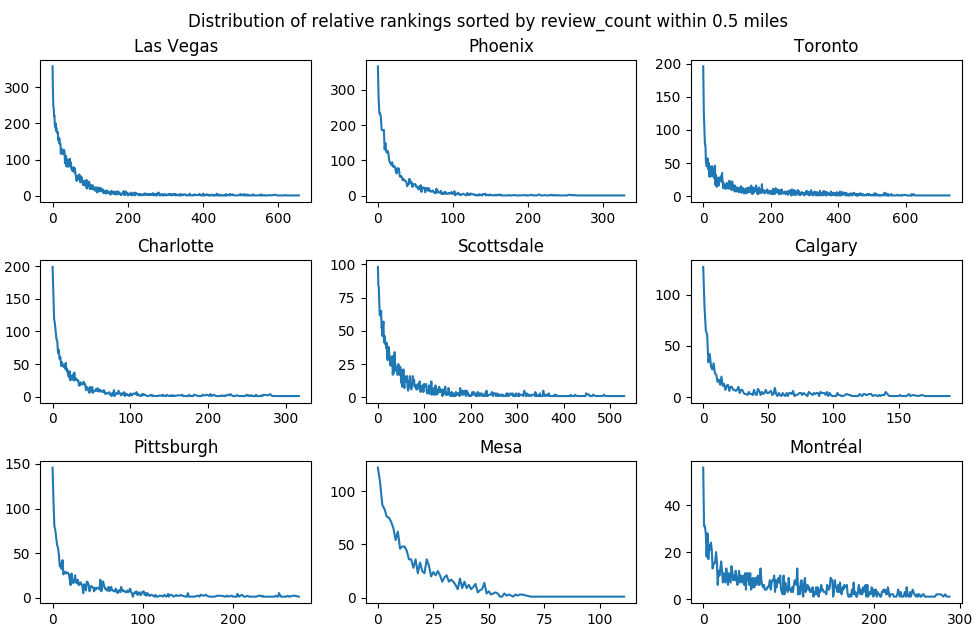

In [155]:
# Distribution of relative ranks sorted by review count within 0.5 miles

rank_dist_0_5mi = rank_by_city.copy()

index = 0
fig, axs = plt.subplots(3, 3, constrained_layout=True)
axs = axs.flatten()
for city in top_cities[:9]:
    counter = collections.Counter(rank_dist_0_5mi[city])
    x, y = zip(*counter.items())
    ax = axs[index]
    ax.set_title(city)
    ax.plot(x, y)
    index += 1
fig.suptitle('Distribution of relative rankings sorted by review_count within 0.5 miles')
plt.show()

<IPython.core.display.Javascript object>


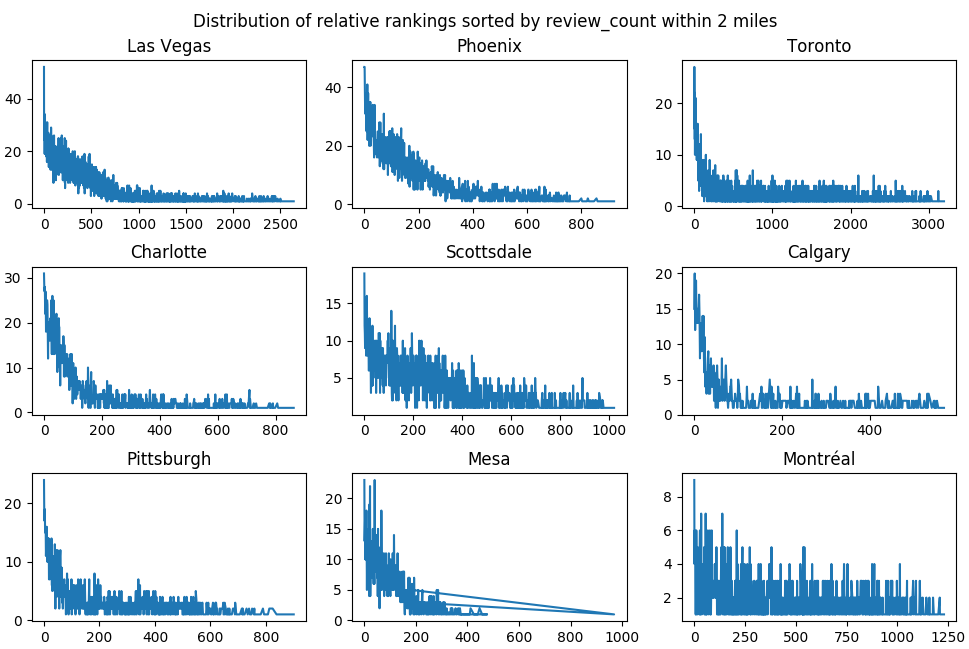

In [157]:
# Distribution of relative ranks sorted by review count within 2 miles

rank_dist_2mi = rank_by_city.copy()

index = 0
fig, axs = plt.subplots(3, 3, constrained_layout=True)
axs = axs.flatten()
for city in top_cities[:9]:
    counter = collections.Counter(rank_dist_2mi[city])
    x, y = zip(*counter.items())
    ax = axs[index]
    ax.set_title(city)
    ax.plot(x, y)
    index += 1
fig.suptitle('Distribution of relative rankings sorted by review_count within 2 miles')
plt.show()

<IPython.core.display.Javascript object>


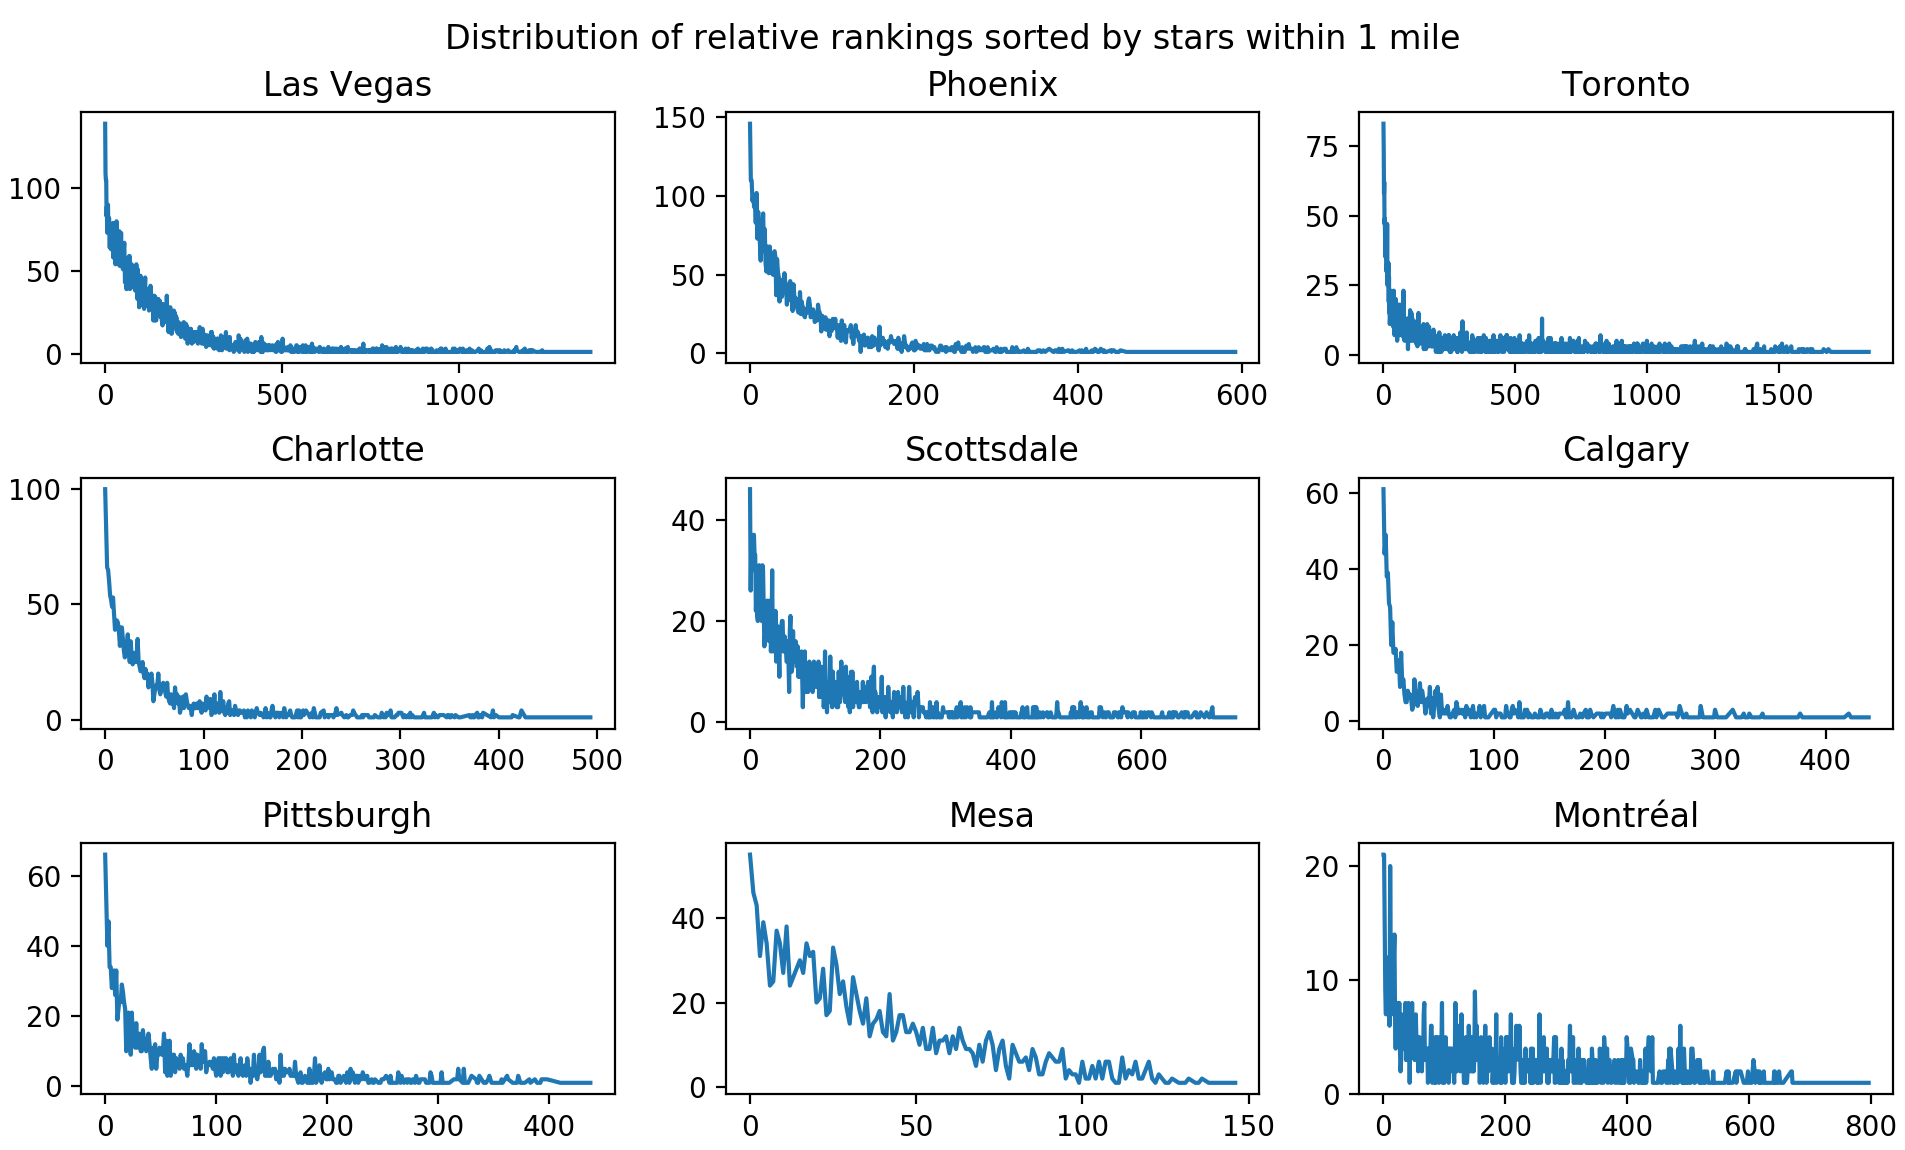

In [163]:
# Distribution of relative ranks sorted by stars within 1 mile

rank_by_stars_dist_1mi = rank_by_city.copy()

index = 0
fig, axs = plt.subplots(3, 3, constrained_layout=True)
axs = axs.flatten()
for city in top_cities[:9]:
    counter = collections.Counter(rank_by_stars_dist_1mi[city])
    x, y = zip(*counter.items())
    ax = axs[index]
    ax.set_title(city)
    ax.plot(x, y)
    index += 1
fig.suptitle('Distribution of relative rankings sorted by stars within 1 mile')
plt.show()

<IPython.core.display.Javascript object>


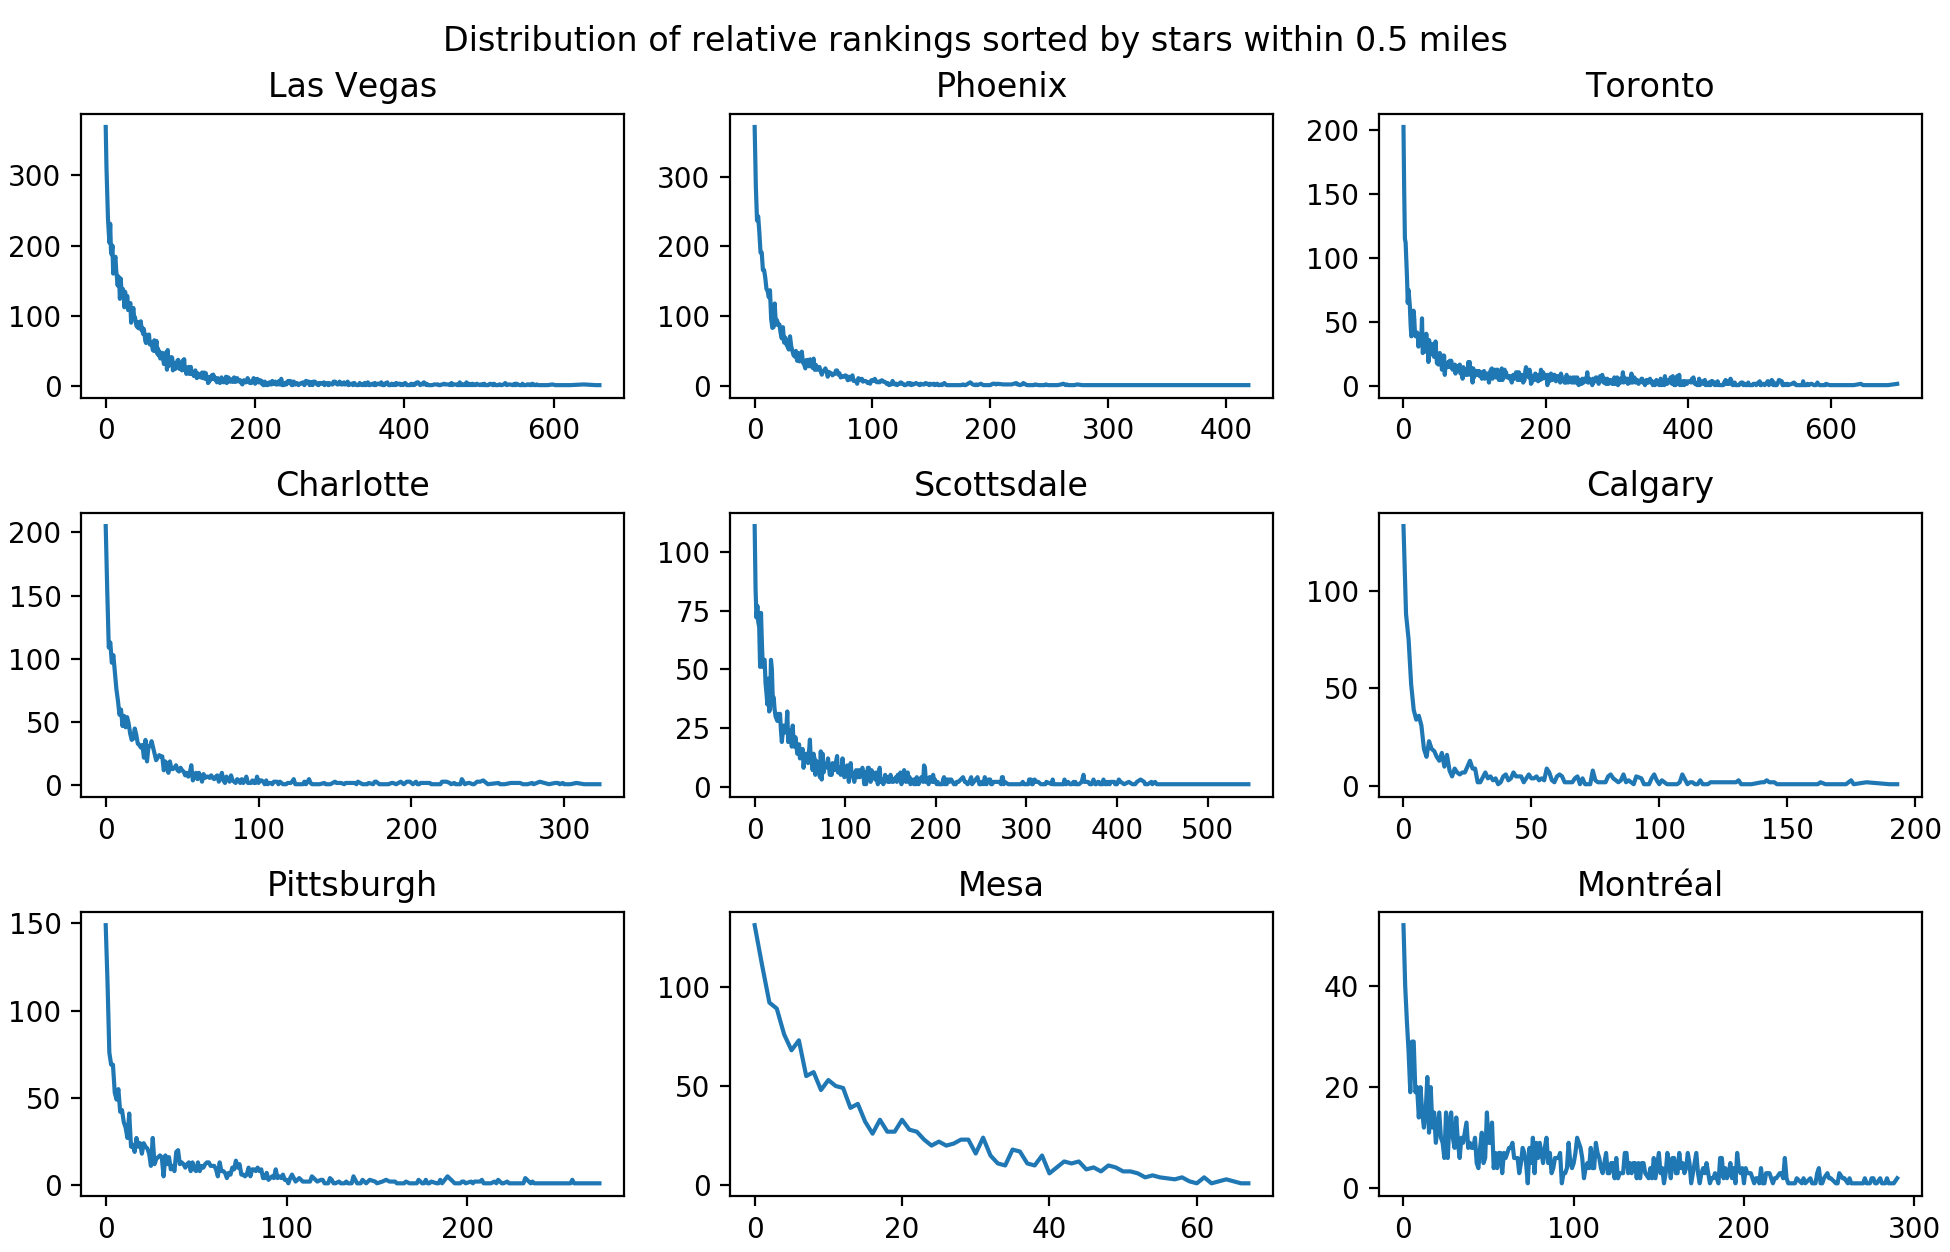

In [165]:
# Distribution of relative ranks sorted by stars within 0.5 miles

rank_by_stars_dist_0_5mi = rank_by_city.copy()

index = 0
fig, axs = plt.subplots(3, 3, constrained_layout=True)
axs = axs.flatten()
for city in top_cities[:9]:
    counter = collections.Counter(rank_by_stars_dist_0_5mi[city])
    x, y = zip(*counter.items())
    ax = axs[index]
    ax.set_title(city)
    ax.plot(x, y)
    index += 1
fig.suptitle('Distribution of relative rankings sorted by stars within 0.5 miles')
plt.show()

<IPython.core.display.Javascript object>


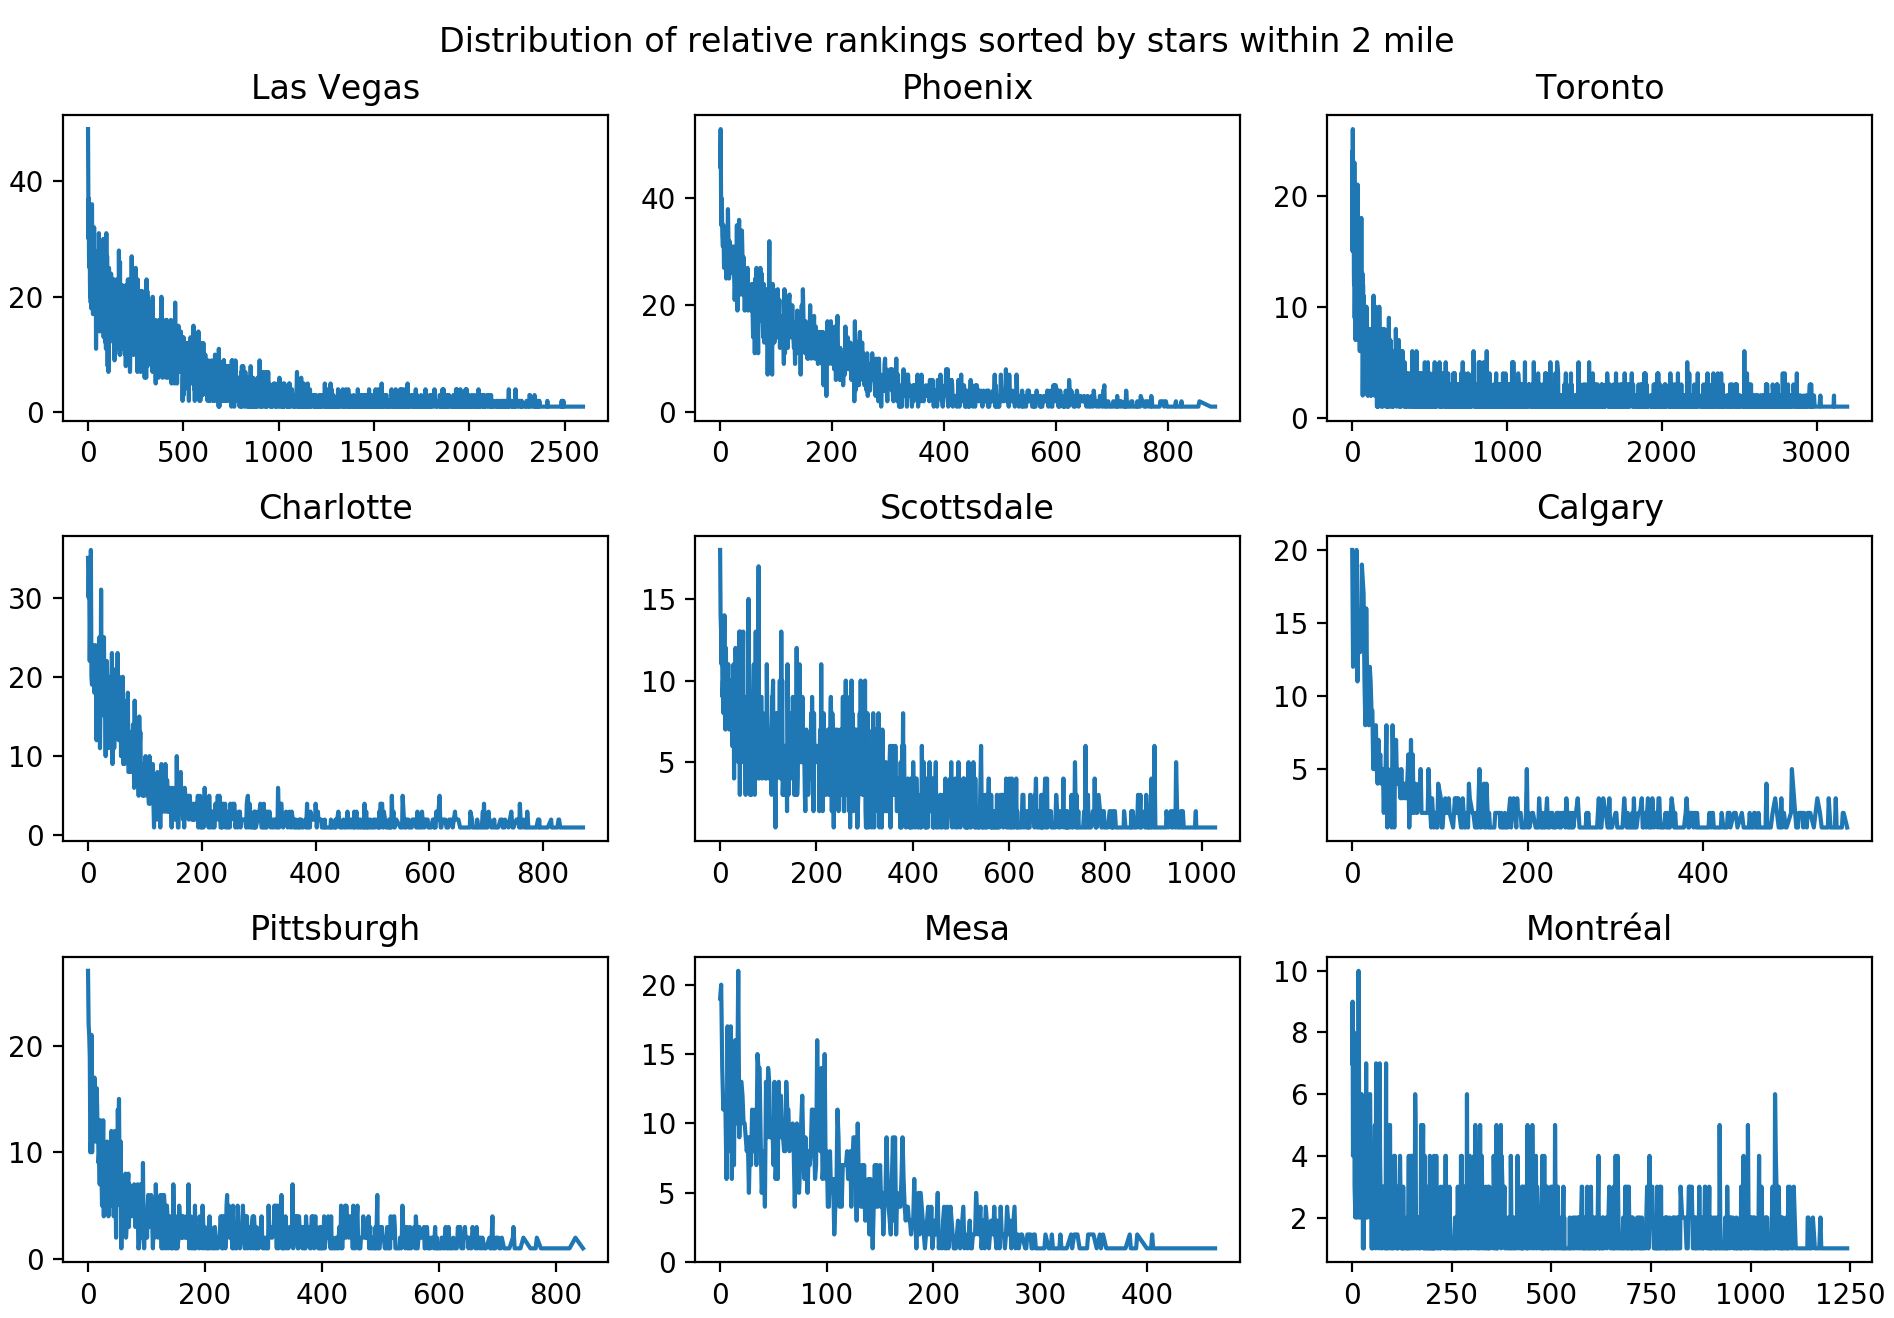

In [162]:
# Distribution of relative ranks sorted by stars within 2 mile

rank_by_stars_dist_2mi = rank_by_stars_dist_1mi.copy()

index = 0
fig, axs = plt.subplots(3, 3, constrained_layout=True)
axs = axs.flatten()
for city in top_cities[:9]:
    counter = collections.Counter(rank_by_stars_dist_2mi[city])
    x, y = zip(*counter.items())
    ax = axs[index]
    ax.set_title(city)
    ax.plot(x, y)
    index += 1
fig.suptitle('Distribution of relative rankings sorted by stars within 2 mile')
plt.show()

# Distribution of "Top" Businesses

# Spatial Clustering

Nodes are all the businesses. We connect nodes by their physical distance and calculate the clustering coefficient.

In [170]:
# Construct graph based on geographical closeness

city = u'Las Vegas'
distance_bin = list(range(100, 5000, 100))
cluster_coeff_bin = []

G = snap.TNGraph.New()

business_in_city = list(db.city_business.find({
    'city' : city
}))
business_to_index = {}
index_to_business = {}

for index, business in enumerate(business_in_city):
    G.AddNode(index)
    business_to_index[business['business_id']] = index
    index_to_business[index] = business

for dist_index, distance in enumerate(distance_bin):
    for node_i in range(G.GetNodes()):
        business_i = index_to_business[node_i]
        
        neighbors = list(db.city_business.find({
                'city' : city,
                'loc' : { '$near': { '$geometry': { 'type' : 'Point' , 'coordinates' : [ business_i['longitude'], business_i['latitude'] ] }, 
                                    '$minDistance': (distance_bin[dist_index - 1] if dist_index > 0 else 0), 
                                    '$maxDistance': distance 
                                   } },
            },{
                '_id': 0, 'business_id': 1
            },
        ))
        
        for node_j in neighbors:
            node_j = business_to_index[node_j['business_id']]
            if not G.IsEdge(node_i, node_j):
                G.AddEdge(node_i, node_j)
    
    DegToCCfV = snap.TFltPrV()
    result = snap.GetClustCfAll(G, DegToCCfV)
    cluster_coeff_bin.append(result[0])
    print 'distance = ', distance, 'clustering coeff = ', result[0]

distance =  100 clustering coeff =  0.649017604829
distance =  200 clustering coeff =  0.737601432017
distance =  300 clustering coeff =  0.770982656518
distance =  400 clustering coeff =  0.786332762582
distance =  500 clustering coeff =  0.793748885563
distance =  600 clustering coeff =  0.795037559915
distance =  700 clustering coeff =  0.794291820028
distance =  800 clustering coeff =  0.789505215007
distance =  900 clustering coeff =  0.786093052285
distance =  1000 clustering coeff =  0.781555035188
distance =  1100 clustering coeff =  0.776992752856
distance =  1200 clustering coeff =  0.771023447252
distance =  1300 clustering coeff =  0.76349805713
distance =  1400 clustering coeff =  0.754536544549
distance =  1500 clustering coeff =  0.744284167441
distance =  1600 clustering coeff =  0.735326338951
distance =  1700 clustering coeff =  0.729487703074
distance =  1800 clustering coeff =  0.726896607366
distance =  1900 clustering coeff =  0.726241050115
distance =  2000 clust

KeyboardInterrupt: 

What if we only focus on businesses with more comments / higher stars? 

In [172]:
# Construct graph based on geographical closeness

city = u'Las Vegas'
distance_bin = list(range(100, 2000, 100))
cluster_coeff_bin_limit_reviews = []

G = snap.TNGraph.New()

business_in_city = list(db.city_business.find({
    'city' : city,
    'review_count' : { '$gte' : 100 }
}))
business_to_index = {}
index_to_business = {}

for index, business in enumerate(business_in_city):
    G.AddNode(index)
    business_to_index[business['business_id']] = index
    index_to_business[index] = business

for dist_index, distance in enumerate(distance_bin):
    for node_i in range(G.GetNodes()):
        business_i = index_to_business[node_i]
        
        neighbors = list(db.city_business.find({
                'city' : city,
                'review_count' : { '$gte' : 100 }, 
                'loc' : { '$near': { '$geometry': { 'type' : 'Point' , 'coordinates' : [ business_i['longitude'], business_i['latitude'] ] }, 
                                    '$minDistance': (distance_bin[dist_index - 1] if dist_index > 0 else 0), 
                                    '$maxDistance': distance 
                                   } },
            },{
                '_id': 0, 'business_id': 1
            },
        ))
        
        for node_j in neighbors:
            node_j = business_to_index[node_j['business_id']]
            if not G.IsEdge(node_i, node_j):
                G.AddEdge(node_i, node_j)
    
    DegToCCfV = snap.TFltPrV()
    result = snap.GetClustCfAll(G, DegToCCfV)
    cluster_coeff_bin_limit_reviews.append(result[0])
    print 'distance = ', distance, 'clustering coeff = ', result[0]

distance =  100 clustering coeff =  0.512492795728
distance =  200 clustering coeff =  0.661023823434
distance =  300 clustering coeff =  0.726661230932
distance =  400 clustering coeff =  0.752717395965
distance =  500 clustering coeff =  0.773287515007
distance =  600 clustering coeff =  0.78390218069
distance =  700 clustering coeff =  0.789829086439
distance =  800 clustering coeff =  0.792574290647
distance =  900 clustering coeff =  0.796259000425
distance =  1000 clustering coeff =  0.795397120316
distance =  1100 clustering coeff =  0.791320861396
distance =  1200 clustering coeff =  0.786672202239
distance =  1300 clustering coeff =  0.783154049185
distance =  1400 clustering coeff =  0.776466151856
distance =  1500 clustering coeff =  0.7711371974
distance =  1600 clustering coeff =  0.764951037607
distance =  1700 clustering coeff =  0.760411144955
distance =  1800 clustering coeff =  0.758782593139
distance =  1900 clustering coeff =  0.759142451409


In [173]:
# Construct graph based on geographical closeness

city = u'Las Vegas'
distance_bin = list(range(100, 2000, 100))
cluster_coeff_bin_limit_reviews_200 = []

G = snap.TNGraph.New()

business_in_city = list(db.city_business.find({
    'city' : city,
    'review_count' : { '$gte' : 200 }
}))
business_to_index = {}
index_to_business = {}

for index, business in enumerate(business_in_city):
    G.AddNode(index)
    business_to_index[business['business_id']] = index
    index_to_business[index] = business

for dist_index, distance in enumerate(distance_bin):
    for node_i in range(G.GetNodes()):
        business_i = index_to_business[node_i]
        
        neighbors = list(db.city_business.find({
                'city' : city,
                'review_count' : { '$gte' : 200 }, 
                'loc' : { '$near': { '$geometry': { 'type' : 'Point' , 'coordinates' : [ business_i['longitude'], business_i['latitude'] ] }, 
                                    '$minDistance': (distance_bin[dist_index - 1] if dist_index > 0 else 0), 
                                    '$maxDistance': distance 
                                   } },
            },{
                '_id': 0, 'business_id': 1
            },
        ))
        
        for node_j in neighbors:
            node_j = business_to_index[node_j['business_id']]
            if not G.IsEdge(node_i, node_j):
                G.AddEdge(node_i, node_j)
    
    DegToCCfV = snap.TFltPrV()
    result = snap.GetClustCfAll(G, DegToCCfV)
    cluster_coeff_bin_limit_reviews_200.append(result[0])
    print 'distance = ', distance, 'clustering coeff = ', result[0]

distance =  100 clustering coeff =  0.456132125696
distance =  200 clustering coeff =  0.61511140285
distance =  300 clustering coeff =  0.673802093758
distance =  400 clustering coeff =  0.704797212903
distance =  500 clustering coeff =  0.736987081678
distance =  600 clustering coeff =  0.763059779984
distance =  700 clustering coeff =  0.778650115504
distance =  800 clustering coeff =  0.781550371086
distance =  900 clustering coeff =  0.784336642132
distance =  1000 clustering coeff =  0.788696942938
distance =  1100 clustering coeff =  0.7842716821
distance =  1200 clustering coeff =  0.782503531716
distance =  1300 clustering coeff =  0.781370534419
distance =  1400 clustering coeff =  0.776066218902
distance =  1500 clustering coeff =  0.776779013619
distance =  1600 clustering coeff =  0.773792015385
distance =  1700 clustering coeff =  0.772530919567
distance =  1800 clustering coeff =  0.772263495079
distance =  1900 clustering coeff =  0.772875826556


# Temporal Analysis

We divide reviews by year and month -- and then we can analyse the growth for each given review